In [14]:
# SET ARGUMENTS
# input_path <- snakemake@input[["counts_scaled"]]
input_path <- "/scratch/tweber/DATA/MC_DATA/STOCKS/2023-07-28-HL25JAFX5/KM1116LENTIx01/counts/multistep_normalisation/KM1116LENTIx01.txt.scaled.gz"
# gc_path <- snakemake@params[["gc_matrix"]]
gc_path = "/g/korbel2/weber/workspace/ashleys-qc-pipeline/workflow/data/GC/hg38.GC_matrix.txt.gz"
save_path = "TEST.txt.gz"
# save_path <- snakemake@output[["counts_scaled_gc"]]
plot <- TRUE
# min_reads <- snakemake@params[["gc_min_reads"]] # <- 5
min_reads = 5
# n_subsample <- snakemake@params[["gc_n_subsample"]] # <- 1000
n_subsample = 1000

print(gc_path)


# open files
counts <- data.table::fread(input_path, header = T)
GC_matrix <- data.table::fread(gc_path, header = T)

# reformat GC_matrix
# find column containing GC counts and rename to 'GC%'

idx <- which(grepl("GC", colnames(GC_matrix), fixed = TRUE))
colnames(GC_matrix)[[idx]] <- "GC%"

# check GC plots
if (plot) {
  # import libraries
  library(ggplot2)
  library(ggpubr)
}


# check files
if (!all(c("cell", "chrom", "start", "end", "w", "c") %in% colnames(counts))) {
  message("count file does not contain required columns: 'cell', 'chrom', 'start', 'end', 'w', 'c'")
  message("Usage: Rscript GC_correction.R count-file.txt.gz gc-matrix.txt output.txt.gz")
  stop()
}
if (!all(c("chrom", "start", "end", "GC%") %in% colnames(GC_matrix))) {
  message("GC_matrix file does not contain required columns: 'chrom', 'start', 'end', 'GC%'")
  message("Usage: Rscript GC_correction.R count-file.txt.gz gc-matrix.txt output.txt.gz")
  stop()
}
if (!(all(unique(counts$chrom) %in% unique(GC_matrix$chrom)) &
  all(unique(counts$start) %in% unique(GC_matrix$start)) &
  all(unique(counts$end) %in% unique(GC_matrix$end)))) {
  message("bin features ('crhom', 'start', 'end') do not match between count file and GC matrix")
  message("make sure to choose files with identical bin sizes")
}


# green light message
# message(paste("\ncount file:", args[1]))
# message(paste("GC matrix file:", args[2]))
# message(paste("savepath:", args[3]))
message("preprocessing...\n")


#################
# Preprocessing #
#################

# force cell column to factor
counts$cell <- as.factor(counts$cell)

# convert strandseq count file to count matrix
counts$tot_count <- counts$c + counts$w

######################
# GC bias correction #
######################


counts <- merge(counts, GC_matrix[, c("chrom", "start", "GC%")], by = c("chrom", "start"), all.x = T)


#############################
# lowess fit and correction #
#############################
# lowess fit
z <- lowess(subsample$`GC%`, subsample$log_count_norm)

# ################
# # SAVING PLOTS #
# ################

# adjust tot count to closest predicted GC value
idxs <- sapply(as.numeric(counts$`GC%`), FUN = function(a) {
  which.min(abs(z$x - a))
})
idxs[lapply(idxs, length) == 0] <- NA
counts$pred <- z$y[unlist(idxs)]
counts$tot_count_gc <- log(counts$tot_count / median(counts$tot_count)) - counts$pred
counts$tot_count_gc <- exp(counts$tot_count_gc) * median(counts$tot_count)


# filter data for subsampling
c <- counts[counts$tot_count >= min_reads]
if (dim(c)[[1]] == 0) {
  stop(paste("there are no bins with more than", min_reads, "reads"))
}
c$`GC%` <- as.numeric(c$`GC%`)
c$log_count_norm <- log(c$tot_count) - log(median(c$tot_count))
not.na <- !is.na(c$`GC%`)
s <- c[not.na]

# subsample from quantiles
s$GC_bin <- cut(s$`GC%`, breaks = c(quantile(s$`GC%`, probs = seq(0, 1, by = 1 / 10))), labels = seq(1, 10, by = 1), include.lowest = TRUE)

subsample <- data.frame()
for (i in seq(10)) {
  sbin <- s[s$GC_bin == i]
  m <- min(dim(sbin)[1], n_subsample)
  sa <- sbin[sample(nrow(sbin), size = m), ]
  subsample <- rbind(subsample, sa)
}

#if (plot) {
#  sidxs <- sapply(as.numeric(subsample$`GC%`), FUN = function(a) {
#    which.min(abs(z$x - a))
#  })
#  sidxs[lapply(sidxs, length) == 0] <- NA


#  subsample$pred <- z$y[unlist(sidxs)]
#  subsample$tot_count_gc <- log(subsample$tot_count / median(subsample$tot_count)) - subsample$pred
#  subsample$tot_count_gc <- exp(subsample$tot_count_gc) * median(subsample$tot_count)

#  z$y2 <- exp(z$y) * median(subsample$tot_count)
#  ymin <- min(cbind(subsample$tot_count, subsample$tot_count_gc))
#  ymax <- max(cbind(subsample$tot_count, subsample$tot_count_gc))

#  p1 <- ggplot(subsample, aes(`GC%`, tot_count)) +
#    geom_point(size = 1, alpha = .2) +
#    ggtitle("raw") +
#    ylim(ymin, ymax) +
#    xlab("GC_content") +
#    ylab("read count") +
#    geom_line(data = as.data.frame(z), aes(x, y2), color = "red")

#    p2 <- ggplot(subsample, aes(`GC%`, tot_count_gc)) +
#      geom_point(size = 1, alpha = .2) +
#      ggtitle("gc corrected") +
#      ylim(ymin, ymax) +
#      xlab("GC content") +
#      ylab("read count") +
#      geom_line(data = as.data.frame(z_after_correction), aes(x, y), color = "blue")


#  corr_plot <- ggarrange(p1, p2)


#  # save plots
#  # ggsave(snakemake@output[["plot"]], corr_plot, width = 12, height = 6)
#}

## adjust w, c and fill NAs
#counts$w <- (counts$w * counts$tot_count / counts$tot_count_gc)
#counts$c <- (counts$c * counts$tot_count / counts$tot_count_gc)
#counts$w[is.na(counts$w)] <- 0
#counts$c[is.na(counts$c)] <- 0
#counts$tot_count[is.na(counts$tot_count)] <- 0

#output <- counts[, c("chrom", "start", "end", "sample", "cell", "w", "c", "tot_count", "class")]

## data.table::fwrite(output, save_path)

[1] "/g/korbel2/weber/workspace/ashleys-qc-pipeline/workflow/data/GC/hg38.GC_matrix.txt.gz"


preprocessing...




In [ ]:
lowess_values_before <- data.frame(GC = z$x, Count = z$y)
lowess_values_after <- data.frame(GC = z_after_correction$x, Count = z_after_correction$y)


In [10]:
subsample

chrom,start,end,sample,cell,c,w,class,tot_count,GC%,log_count_norm,GC_bin
<chr>,<int>,<int>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
chr8,88800000,89000000,KM1116LENTIx01,KM1116LENTIx01PE20413,6.007153,1.802146,WC,7.809298,34.6935,-0.882211672,1
chr12,84400000,84600000,KM1116LENTIx01,KM1116LENTIx01PE20461,8.313464,3.325386,WC,11.638850,33.9890,-0.483178167,1
chr13,84000000,84200000,KM1116LENTIx01,KM1116LENTIx01PE20457,8.273290,5.909493,WC,14.182783,34.5355,-0.285497999,1
chr5,110400000,110600000,KM1116LENTIx01,KM1116LENTIx01PE20492,9.628694,6.740086,WC,16.368779,35.1985,-0.142150968,1
chr4,65200000,65400000,KM1116LENTIx01,KM1116LENTIx01PE20438,8.051199,0.000000,CC,8.051199,34.3080,-0.851705742,1
chr2,212200000,212400000,KM1116LENTIx01,KM1116LENTIx01PE20459,11.523811,0.000000,CC,11.523811,33.5365,-0.493111391,1
chr8,112200000,112400000,KM1116LENTIx01,KM1116LENTIx01PE20439,8.241882,2.747294,WC,10.989176,33.9760,-0.540616044,1
chr5,22400000,22600000,KM1116LENTIx01,KM1116LENTIx01PE20403,3.592205,7.184410,WC,10.776615,35.1925,-0.560148287,1
chr7,115600000,115800000,KM1116LENTIx01,KM1116LENTIx01PE20410,0.000000,15.797404,WW,15.797404,34.8020,-0.177681177,1


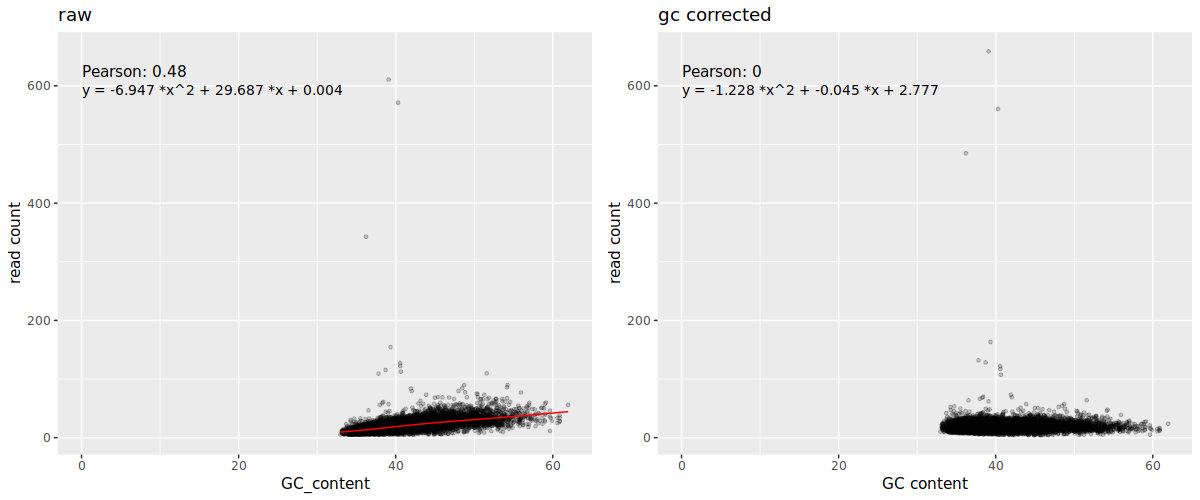

In [19]:
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 100)

#############################
# lowess fit and correction #
#############################
# lowess fit
z <- lowess(subsample$`GC%`, subsample$log_count_norm)
z_after_correction <- lowess(subsample$`GC%`, log(subsample$tot_count_gc - log(median(subsample$tot_count_gc))))


######################
# Pearson correction #
######################
pearson_before_correction <- cor(subsample$'GC%', subsample$tot_count, method="pearson")
pearson_after_correction <- cor(subsample$'GC%', subsample$tot_count_gc, method="pearson")



lowess_values_before <- data.frame(GC = z$x, Count = z$y)
lowess_values_after <- data.frame(GC = z_after_correction$x, Count = z_after_correction$y)

# Polynomial fit for lowess values before and after correction
fit_before <- lm(Count ~ poly(GC, 2), data=lowess_values_before)
fit_after <- lm(Count ~ poly(GC, 2), data=lowess_values_after)

equation_before <- paste("y =", round(fit_before$coefficients[3], 3), "*x^2 +", round(fit_before$coefficients[2], 3), "*x +", round(fit_before$coefficients[1], 3))
equation_after <- paste("y =", round(fit_after$coefficients[3], 3), "*x^2 +", round(fit_after$coefficients[2], 3), "*x +", round(fit_after$coefficients[1], 3))


# ################
# # SAVING PLOTS #
# ################

# adjust tot count to closest predicted GC value
idxs <- sapply(as.numeric(counts$`GC%`), FUN = function(a) {
  which.min(abs(z$x - a))
})
idxs[lapply(idxs, length) == 0] <- NA
counts$pred <- z$y[unlist(idxs)]
counts$tot_count_gc <- log(counts$tot_count / median(counts$tot_count)) - counts$pred
counts$tot_count_gc <- exp(counts$tot_count_gc) * median(counts$tot_count)

if (plot) {
    sidxs <- sapply(as.numeric(subsample$`GC%`), FUN = function(a) {
    which.min(abs(z$x - a))
    })
    sidxs[lapply(sidxs, length) == 0] <- NA


    subsample$pred <- z$y[unlist(sidxs)]
    subsample$tot_count_gc <- log(subsample$tot_count / median(subsample$tot_count)) - subsample$pred
    subsample$tot_count_gc <- exp(subsample$tot_count_gc) * median(subsample$tot_count)

    z$y2 <- exp(z$y) * median(subsample$tot_count)
    ymin <- min(cbind(subsample$tot_count, subsample$tot_count_gc))
    ymax <- max(cbind(subsample$tot_count, subsample$tot_count_gc))

    p1 <- ggplot(subsample, aes(`GC%`, tot_count)) +
      geom_point(size = 1, alpha = .2) +
      ggtitle("raw") +
      ylim(ymin, ymax) +
      xlab("GC_content") +
      ylab("read count") +
      geom_line(data = as.data.frame(z), aes(x, y2), color = "red") +
      annotate("text", x = 0.05, y = ymax * 0.95, label = paste("Pearson:", round(pearson_before_correction, 2)), hjust = 0) +
      annotate("text", x = 0.05, y = ymax * 0.90, label = equation_before, hjust = 0, size=3.5)

    p2 <- ggplot(subsample, aes(`GC%`, tot_count_gc)) +
      geom_point(size = 1, alpha = .2) +
      ggtitle("gc corrected") +
      ylim(ymin, ymax) +
      xlab("GC content") +
      ylab("read count") +
      geom_line(data = as.data.frame(z_after_correction), aes(x, y), color = "blue") +
      annotate("text", x = 0.05, y = ymax * 0.95, label = paste("Pearson:", round(pearson_after_correction, 2)), hjust = 0) +
      annotate("text", x = 0.05, y = ymax * 0.90, label = equation_after, hjust = 0, size=3.5)


  corr_plot <- ggarrange(p1, p2)
}
corr_plot

In [9]:
head(subsample$`GC%`)
head(subsample$tot_count_gc)


[1] 35.6165 34.3490 34.2185 34.5980 34.6820 35.0955

[1] 23.006682 19.351240 23.653279  9.941569 12.295808 16.443087

In [16]:
head(lowess_values_before)

,GC,Count
,<dbl>,<dbl>
1,32.9485,-0.6782071
2,33.0995,-0.6625555
3,33.1630,-0.6559736
4,33.1630,-0.6559736
5,33.1700,-0.6552480
6,33.2005,-0.6520866


In [17]:
head(lowess_values_after)

,GC,Count
,<dbl>,<dbl>
1,32.9485,2.747273
2,33.0995,2.748791
3,33.1630,2.749429
4,33.1630,2.749429
5,33.1700,2.749499
6,33.2005,2.749806
